# Lecture 5 Extension (China A-shares): BYD vs SAIC - Comparative Financial Ratio Analysis

This notebook applies the Lecture 5 Part 2 ratio framework to a China A-share comparison between:
- BYD Co., Ltd. (002594.SZ) - new-energy vehicle (NEV) manufacturer
- SAIC Motor Corporation (600104.SH) - traditional automaker with mixed powertrain exposure

Data are taken from publicly available financial statements (Eastmoney; accessed programmatically for reproducibility). The analysis retains statement observations from 2022 onward and visualizes trends over 2024-2025.

## Ratio set (definitions)

**Profitability**
- Gross margin = (Revenue - Cost of revenue) / Revenue
- Operating margin = Operating income / Revenue
- Net margin = Net income / Revenue

**Liquidity**
- Current ratio = Current assets / Current liabilities
- Quick ratio = (Current assets - Inventory) / Current liabilities
- Cash ratio = Cash / Current liabilities

**Efficiency**
- Inventory turnover = Cost of revenue / Inventory
- Asset turnover = Revenue / Total assets

**Returns**
- ROA = Net income / Total assets
- ROE = Net income / Total equity
- Effective tax rate = Income tax / Pretax income
- NOPAT = Operating income x (1 - effective tax rate)
- ROIC = NOPAT / (Total debt + Total equity)
- ROCE = EBIT / (Total assets - Current liabilities)

## Practical notes

- Balance sheet items are end-of-period stocks; income statement items are period flows.
- Reported definitions vary across practitioners. The formulas above are used consistently throughout this notebook for comparability.
- A local copy of the downloaded statements and computed ratios is stored under `data/china_auto/` to support reproducibility and offline use.


In [1]:
# Imports & global settings

from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from IPython.display import display

import akshare as ak

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

CACHE_DIR = Path('data/china_auto')
CACHE_DIR.mkdir(parents=True, exist_ok=True)

USE_LOCAL_CACHE = True     # Prefer cached files when available
FORCE_REFRESH = False      # Re-download even if cache exists

BYD = 'sz002594'           # 002594.SZ
SAIC = 'sh600104'          # 600104.SH

FILTER_START_DATE = '2022-01-01'  # Keep observations from 2022 onward
PLOT_START = '2024-01-01'
PLOT_END = '2025-12-31'

print('Environment ready.')


Environment ready.


## Financial reporting conventions and alignment

For China A-share interim reports, income statement line items are typically reported on a year-to-date (cumulative) basis:
- Q1 report: cumulative Q1
- Interim report (H1): cumulative Q1-Q2
- Q3 report: cumulative Q1-Q3
- Annual report: cumulative Q1-Q4 (full year)

To obtain single-quarter flows (e.g., Q3 revenue), use within-year differences between adjacent reporting dates. This allows margins and return metrics to reflect single-quarter performance rather than year-to-date accumulation.

In ratio construction, each quarterly flow is paired with the balance sheet at the same quarter-end date (stocks at period end). For visualization, quarterly observations are linearly interpolated to a monthly grid; interpolation is for chart smoothness only and does not create new financial disclosures.


In [2]:
def _cache_path(symbol, kind):
    return CACHE_DIR / f"{symbol}_{kind}.csv.gz"


def fetch_with_retry(fetch_fn, *, symbol, retries=4, sleep_s=2.0):
    last_err = None
    for attempt in range(1, retries + 1):
        try:
            df = fetch_fn(symbol=symbol)
            if df is None or getattr(df, "empty", True):
                raise ValueError("Empty dataframe")
            return df
        except Exception as e:
            last_err = e
            if attempt == retries:
                raise
            print(f"[{symbol}] {fetch_fn.__name__} failed ({type(e).__name__}): {e}")
            time.sleep(sleep_s * attempt)
    raise last_err


def load_or_fetch(symbol, kind, fetch_fn):
    path = _cache_path(symbol, kind)
    if USE_LOCAL_CACHE and (not FORCE_REFRESH) and path.exists():
        print(f"Loading cache: {path}")
        return pd.read_csv(path, compression="gzip")

    print(f"Downloading {kind} for {symbol} ...")
    df = fetch_with_retry(fetch_fn, symbol=symbol)
    df.to_csv(path, index=False, compression="gzip")
    print(f"Saved cache: {path}")
    return df


def normalize_report_date(df, date_col="REPORT_DATE"):
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce").dt.normalize()
    if "UPDATE_DATE" in out.columns:
        out["UPDATE_DATE"] = pd.to_datetime(out["UPDATE_DATE"], errors="coerce")
        out = out.sort_values([date_col, "UPDATE_DATE"])
        out = out.drop_duplicates(subset=[date_col], keep="last")
    else:
        out = out.sort_values([date_col])
        out = out.drop_duplicates(subset=[date_col], keep="last")
    out = out.dropna(subset=[date_col])
    return out


def to_quarterly_from_cumulative(df, cols):
    out = df.copy()
    out[cols] = out[cols].apply(pd.to_numeric, errors="coerce")
    years = out.index.year
    q_vals = out[cols].groupby(years).diff()
    q_vals = q_vals.where(~q_vals.isna(), out[cols])
    return q_vals


def build_quarterly_income(profit_df):
    df = normalize_report_date(profit_df)
    df = df.set_index("REPORT_DATE").sort_index()
    df = df[df.index.month.isin([3, 6, 9, 12])]

    net_col = "PARENTNETPROFIT" if "PARENTNETPROFIT" in df.columns else "NETPROFIT"
    need_cols = [
        "TOTAL_OPERATE_INCOME",
        "OPERATE_COST",
        "OPERATE_PROFIT",
        "TOTAL_PROFIT",
        "INCOME_TAX",
        net_col,
    ]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Profit sheet missing columns: {missing}")

    q = to_quarterly_from_cumulative(df, need_cols)

    out = pd.DataFrame(index=df.index)
    out["Revenue"] = q["TOTAL_OPERATE_INCOME"]
    out["Cost Of Revenue"] = q["OPERATE_COST"]
    out["Operating Income"] = q["OPERATE_PROFIT"]
    out["Pretax Income"] = q["TOTAL_PROFIT"]
    out["Income Tax"] = q["INCOME_TAX"]
    out["Net Income"] = q[net_col]
    return out


DEBT_COLS = [
    "SHORT_LOAN",
    "LONG_LOAN",
    "BOND_PAYABLE",
    "SHORT_BOND_PAYABLE",
    "SHORT_FIN_PAYABLE",
    "PERPETUAL_BOND",
    "PERPETUAL_BOND_PAYBALE",
]


def build_balance(balance_df):
    df = normalize_report_date(balance_df)
    df = df.set_index("REPORT_DATE").sort_index()
    df = df[df.index.month.isin([3, 6, 9, 12])]

    base_cols = [
        "TOTAL_ASSETS",
        "TOTAL_EQUITY",
        "TOTAL_CURRENT_ASSETS",
        "TOTAL_CURRENT_LIAB",
        "INVENTORY",
        "MONETARYFUNDS",
    ]
    missing = [c for c in base_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Balance sheet missing columns: {missing}")

    keep = base_cols + [c for c in DEBT_COLS if c in df.columns]
    out = df[keep].copy()
    for c in keep:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    debt_parts = [c for c in DEBT_COLS if c in out.columns]
    out["Total Debt"] = out[debt_parts].sum(axis=1, min_count=1) if debt_parts else np.nan

    out = out.rename(
        columns={
            "TOTAL_ASSETS": "Total Assets",
            "TOTAL_EQUITY": "Total Equity",
            "TOTAL_CURRENT_ASSETS": "Current Assets",
            "TOTAL_CURRENT_LIAB": "Current Liabilities",
            "INVENTORY": "Inventory",
            "MONETARYFUNDS": "Cash",
        }
    )
    return out[
        [
            "Total Assets",
            "Total Equity",
            "Current Assets",
            "Current Liabilities",
            "Inventory",
            "Cash",
            "Total Debt",
        ]
    ]


def compute_metrics(profit_df, balance_df, *, start_date):
    income_q = build_quarterly_income(profit_df)
    bs = build_balance(balance_df)
    df = income_q.join(bs, how="inner").sort_index()
    df = df[df.index >= pd.Timestamp(start_date)]

    revenue = df["Revenue"]
    cogs = df["Cost Of Revenue"]
    op_income = df["Operating Income"]
    net_income = df["Net Income"]

    assets = df["Total Assets"]
    equity = df["Total Equity"]
    curr_assets = df["Current Assets"]
    curr_liab = df["Current Liabilities"]
    inventory = df["Inventory"]
    cash = df["Cash"]
    debt = df["Total Debt"]

    # Profitability
    gross_profit = revenue - cogs
    gross_margin = gross_profit / revenue
    oper_margin = op_income / revenue
    net_margin = net_income / revenue

    # Liquidity
    current_ratio = curr_assets / curr_liab
    quick_ratio = (curr_assets - inventory) / curr_liab
    cash_ratio = cash / curr_liab

    # Efficiency
    inv_turnover = cogs / inventory
    asset_turnover = revenue / assets

    # Returns
    roa = net_income / assets
    roe = net_income / equity

    # ROIC / ROCE (Part2-style, simplified but transparent)
    pretax = df["Pretax Income"]
    tax = df["Income Tax"]
    tax_rate = (tax / pretax).replace([np.inf, -np.inf], np.nan)
    tax_rate = tax_rate.clip(lower=0, upper=0.4).fillna(0.25)

    nopat = op_income * (1 - tax_rate)
    invested_capital = debt + equity
    capital_employed = assets - curr_liab

    roic = nopat / invested_capital
    roce = op_income / capital_employed

    metrics = pd.DataFrame(
        {
            "Gross Margin": gross_margin,
            "Operating Margin": oper_margin,
            "Net Margin": net_margin,
            "Current Ratio": current_ratio,
            "Quick Ratio": quick_ratio,
            "Cash Ratio": cash_ratio,
            "Inventory Turnover": inv_turnover,
            "Asset Turnover": asset_turnover,
            "ROA": roa,
            "ROE": roe,
            "ROIC": roic,
            "ROCE": roce,
        },
        index=df.index,
    )

    metrics = metrics.replace([np.inf, -np.inf], np.nan)
    return metrics


def to_monthly(df, *, start, end):
    try:
        out = df.resample("ME").interpolate(method="linear")
    except ValueError:
        out = df.resample("M").interpolate(method="linear")
    out = out[(out.index >= pd.Timestamp(start)) & (out.index <= pd.Timestamp(end))]
    return out

In [3]:
byd_profit = load_or_fetch(BYD, "profit_sheet", ak.stock_profit_sheet_by_report_em)
byd_balance = load_or_fetch(BYD, "balance_sheet", ak.stock_balance_sheet_by_report_em)

saic_profit = load_or_fetch(SAIC, "profit_sheet", ak.stock_profit_sheet_by_report_em)
saic_balance = load_or_fetch(SAIC, "balance_sheet", ak.stock_balance_sheet_by_report_em)

byd_metrics_q = compute_metrics(byd_profit, byd_balance, start_date=FILTER_START_DATE)
saic_metrics_q = compute_metrics(saic_profit, saic_balance, start_date=FILTER_START_DATE)

byd_metrics_path = CACHE_DIR / "byd_metrics_quarterly.csv"
saic_metrics_path = CACHE_DIR / "saic_metrics_quarterly.csv"
byd_metrics_q.to_csv(byd_metrics_path)
saic_metrics_q.to_csv(saic_metrics_path)
print("Saved metrics:", byd_metrics_path, saic_metrics_path)

byd_metrics = to_monthly(byd_metrics_q, start=PLOT_START, end=PLOT_END)
saic_metrics = to_monthly(saic_metrics_q, start=PLOT_START, end=PLOT_END)

print("BYD metrics (monthly) preview:")
display(byd_metrics.tail(3))
print("SAIC metrics (monthly) preview:")
display(saic_metrics.tail(3))


Loading cache: data\china_auto\sz002594_profit_sheet.csv.gz
Loading cache: data\china_auto\sz002594_balance_sheet.csv.gz
Loading cache: data\china_auto\sh600104_profit_sheet.csv.gz
Loading cache: data\china_auto\sh600104_balance_sheet.csv.gz
Saved metrics: data\china_auto\byd_metrics_quarterly.csv data\china_auto\saic_metrics_quarterly.csv
BYD metrics (monthly) preview:


,Gross Margin,Operating Margin,Net Margin,Current Ratio,Quick Ratio,Cash Ratio,Inventory Turnover,Asset Turnover,ROA,ROE,ROIC,ROCE
REPORT_DATE,,,,,,,,,,,,
2025-07-31,0.167153,0.042959,0.035891,0.797404,0.511344,0.225841,1.146403,0.230328,0.008223,0.028535,0.023030,0.023743
2025-08-31,0.171650,0.047600,0.038954,0.833863,0.536093,0.234028,1.098256,0.223258,0.008653,0.030120,0.023223,0.024366
2025-09-30,0.176147,0.052241,0.042017,0.870322,0.560843,0.242215,1.050108,0.216187,0.009084,0.031706,0.023415,0.024989


SAIC metrics (monthly) preview:


,Gross Margin,Operating Margin,Net Margin,Current Ratio,Quick Ratio,Cash Ratio,Inventory Turnover,Asset Turnover,ROA,ROE,ROIC,ROCE
REPORT_DATE,,,,,,,,,,,,
2025-07-31,0.098966,0.034352,0.025358,1.176804,1.023687,0.386751,1.934247,0.174233,0.004408,0.011520,0.009615,0.012746
2025-08-31,0.101212,0.034172,0.023543,1.172884,1.022189,0.381801,1.978407,0.176990,0.004157,0.010940,0.009232,0.012976
2025-09-30,0.103458,0.033992,0.021727,1.168963,1.020691,0.376851,2.022568,0.179747,0.003905,0.010359,0.008848,0.013207


## Visualization: 2x2 ratio dashboard

The figure groups ratios into four categories: profitability, liquidity, efficiency, and returns.

- Color encodes the metric within a panel.
- Line style encodes the firm: BYD is solid and SAIC is dashed.

Interpretation should emphasize both within-firm trend dynamics over time and cross-firm differences that align with business-model and capital-structure distinctions between a NEV-focused manufacturer and a traditional automaker.


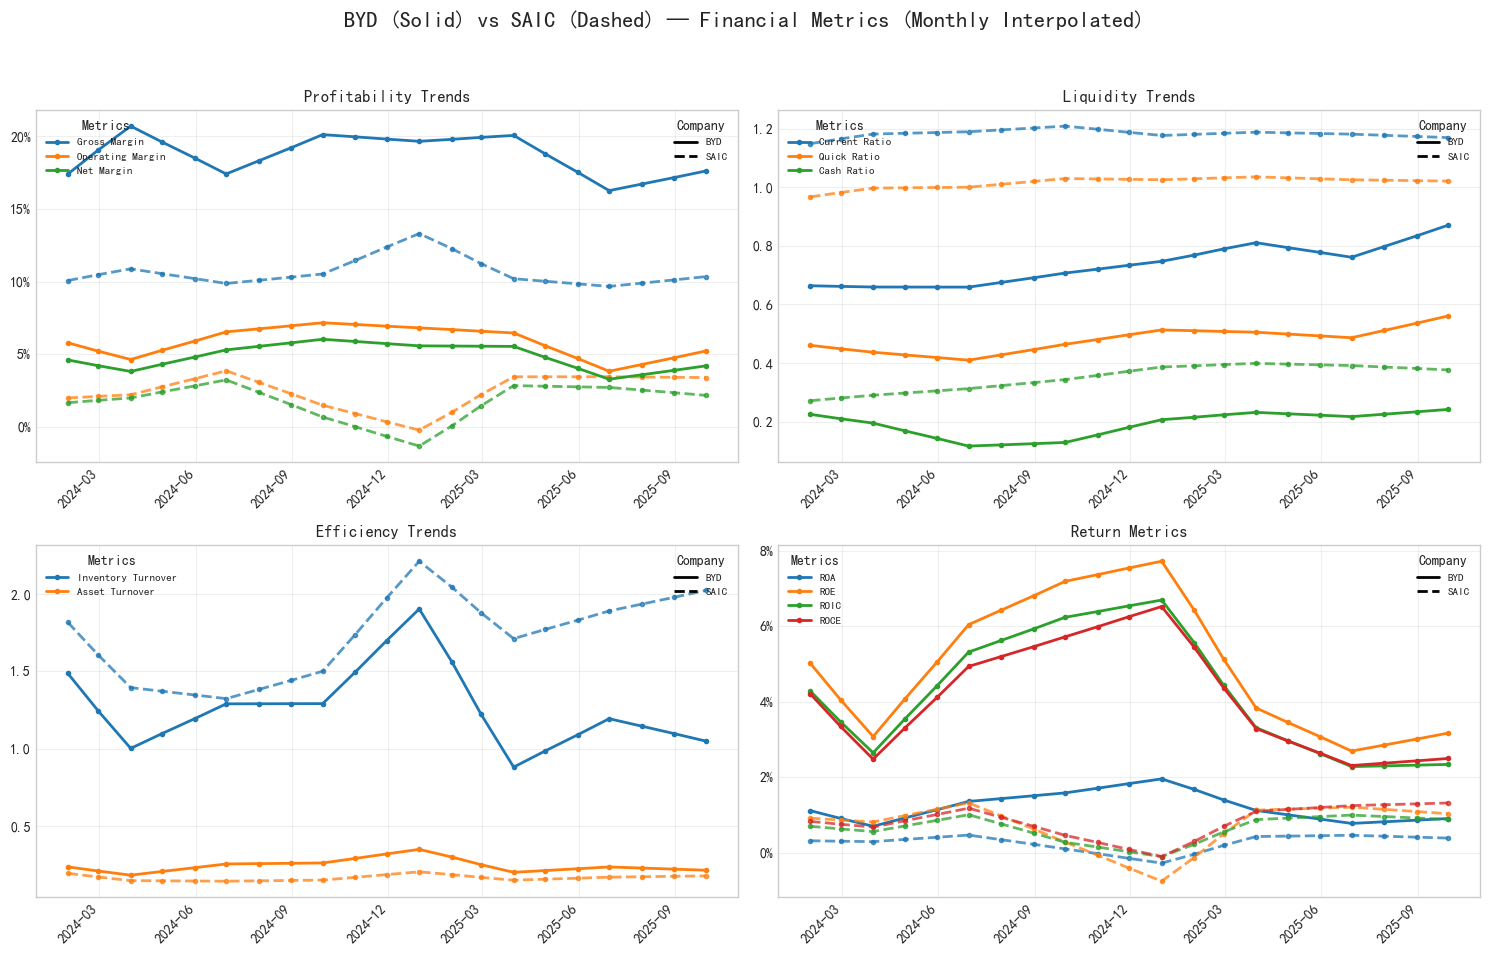

In [4]:
def plot_comparison(df_byd, df_saic):
    if df_byd.empty or df_saic.empty:
        print("Empty metrics dataframe.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(
        "BYD (Solid) vs SAIC (Dashed) — Financial Metrics (Monthly Interpolated)",
        fontsize=16,
        fontweight="bold",
    )

    def plot_category(ax, title, metrics, is_pct=True):
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

        for i, m in enumerate(metrics):
            if m not in df_byd.columns or m not in df_saic.columns:
                continue
            color = colors[i % len(colors)]
            ax.plot(
                df_byd.index,
                df_byd[m],
                marker="o",
                markersize=3,
                linestyle="-",
                linewidth=2,
                color=color,
                label=m,
            )
            ax.plot(
                df_saic.index,
                df_saic[m],
                marker="o",
                markersize=3,
                linestyle="--",
                linewidth=2,
                color=color,
                alpha=0.75,
                label="_nolegend_",
            )

        ax.set_title(title, fontsize=12, fontweight="bold")
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

        if is_pct:
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0%}".format(y)))

        metric_legend = ax.legend(title="Metrics", loc="upper left", fontsize=8)
        ax.add_artist(metric_legend)

        style_handles = [
            Line2D([0], [0], color="black", linestyle="-", linewidth=2, label="BYD"),
            Line2D([0], [0], color="black", linestyle="--", linewidth=2, label="SAIC"),
        ]
        ax.legend(handles=style_handles, title="Company", loc="upper right", fontsize=8)

    # 1) Profitability
    plot_category(
        axes[0, 0],
        "Profitability Trends",
        ["Gross Margin", "Operating Margin", "Net Margin"],
        is_pct=True,
    )

    # 2) Liquidity
    plot_category(
        axes[0, 1],
        "Liquidity Trends",
        ["Current Ratio", "Quick Ratio", "Cash Ratio"],
        is_pct=False,
    )

    # 3) Efficiency
    plot_category(
        axes[1, 0],
        "Efficiency Trends",
        ["Inventory Turnover", "Asset Turnover"],
        is_pct=False,
    )

    # 4) Returns
    plot_category(
        axes[1, 1],
        "Return Metrics",
        ["ROA", "ROE", "ROIC", "ROCE"],
        is_pct=True,
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_comparison(byd_metrics, saic_metrics)

## Discussion prompts

1. **Profitability**: Compare gross margin and net margin dynamics. What cost structure and pricing power differences can explain divergence between the two firms?
2. **Liquidity**: Evaluate current, quick, and cash ratios as indicators of working-capital intensity and short-term financial flexibility.
3. **Efficiency**: Use inventory turnover and asset turnover to discuss operational throughput, channel structure, and asset intensity.
4. **Returns**: Contrast ROA, ROE, ROIC, and ROCE. When can ROE rise while ROIC does not, and what does that imply about leverage versus operating performance?
5. **Caveats**: Consider seasonality, interim reporting conventions, and potential statement restatements when interpreting short-horizon movements.
